In [38]:
import pickle
import pandas as pd
import numpy as np
from numpy import loadtxt
import matplotlib.pyplot as plt
import matplotlib.style as style
from matplotlib_venn import venn2, venn2_circles

In [3]:
chromosomes = ["chr1", "chr2", "chr3", "chr4", "chr5", "chr6", "chr7", "chr8", "chr9", "chr10", "chr11", "chr12",
              "chr13", "chr14", "chr15", "chr16", "chr17", "chr18", "chr19", "chr20", "chr21", "chr22", "chrX", "chrY"]

In [59]:
def read_loops_from_maps(filename):
    """Read loops into dictionary"""
    with open(filename, "r") as f:
        f.readline()
        loop_dict = {}
        interactions = 0
        inter = 0
        for line in f:
            row = line.strip().split()  
            chromosomes = row[0]
            start1, end1, start2, end2 = int(row[1]), int(row[2]), int(row[4]), int(row[5])
            count = int(row[6])
            if chromosomes in loop_dict.keys():
                loop_dict[chromosomes].append((start1, end1, start2, end2, count))
            else:
                loop_dict[chromosomes] = [(start1, end1, start2, end2, count)]
            interactions += 1
        #print(f"Interactions: {interactions}")
        return loop_dict

    
def read_loops_from_hiccups(filename):
    """Read loops into dictionary"""
    with open(filename, "r") as f:
        f.readline()
        loop_dict = {}
        interactions = 0
        inter = 0
        for line in f:
            row = line.strip().split()  
            chromosomes  = row[0]
            start1, end1, start2, end2 = int(row[1]), int(row[2]), int(row[4]), int(row[5])
            #count = int(row[12])
            if chromosomes in loop_dict.keys():
                loop_dict[chromosomes].append((start1, end1, start2, end2))
            else:
                loop_dict[chromosomes] = [(start1, end1, start2, end2)]
            interactions += 1
        #print(f"Interactions: {interactions}")
        return loop_dict

    
def loop_length_distribution(loops_dict, average=True):
    length = 0
    quantity = 0
    loops = []
    max_length = 0
    max_loop = None
    second_max_length = 0
    second_max = None
    third_max_length = 0
    third_max = None
    for i in loops_dict.keys():
        for j in loops_dict[i]:
            middle1 = (j[0] + j[1])/2
            middle2 = (j[3] + j[2])/2
            loop_length = middle2 - middle1
            loops.append(loop_length)
            if loop_length > max_length:
                third_max_length = second_max_length
                second_max_length = max_length
                max_length = loop_length
                third_max = second_max
                second_max = max_loop
                max_loop = (i, j)
    if average:
        #print(f"Max: {max_loop}, length: {max_length}")
        #print(f"Max: {second_max}, length: {second_max_length}")
        #print(f"Max: {third_max}, length: {third_max_length}")
        return round(sum(loops)/len(loops),2)
    else:
        return loops
    
    
def overlap(start1, end1, start2, end2):
    """how much does the range (start1, end1) overlap with (start2, end2)"""
    over = max(max((end2+1-start1), 0) - max((end2-end1), 0) - max((start2-start1), 0), 0)
    if over != 0:
        return True
    return False


def filter_peaks(peaks, interactions):
    """Find all peaks that are located in anchors"""
    chroms = interactions.keys()
    final_peaks = []
    for chrom in chroms:
        chrom_peaks = peaks[peaks['chr'] == chrom]
        chrom_peaks_table = chrom_peaks.to_numpy(copy=True)
        for i in chrom_peaks_table:
            if list(i) not in final_peaks:
                for j in interactions[chrom]:
                    if overlap(i[1], i[2], j[0], j[1]) or overlap(i[1], i[2], j[2], j[3]):
                        final_peaks.append(list(i))
                        break
    return final_peaks


def read_peaks(infile, header_lines=25, chromosomes=chromosomes):
    peaks = {}
    with open(infile, 'r') as f:    
        line=f.readline().strip().split(",")
        while line[0] not in chromosomes:
            line=f.readline().strip().split(",")
        print(line)
        while line:
            if line[0] in chromosomes:
                line = f.readline().strip().split(",")
    pass

def calculate_peak_stats(peak_dict):
    pass


def overlap_loops(loops_1, loops_2, tolerance=0):
    common = []
    for chrom in loops_1["chr1"].unique():
#         print(chrom)
        chrom_loops1 = loops_1[loops_1["chr1"]==chrom].values.tolist()
        chrom_loops2 = loops_2[loops_2["chr1"]==chrom].values.tolist()
        for l1 in chrom_loops1:
            for l2 in chrom_loops2:
                if overlap(l1[1]-tolerance, l1[2]+tolerance, l2[1], l2[2]) and overlap(l1[4]-tolerance, l1[5]+tolerance, l2[4], l2[5]):
                    if l1 not in common:
                        common.append(l1)
    return common


# Plot Heatmaps with Labels
def plot_common_loops(heatmap, labels, outfile=None, show_numbers=True, scale=False):
    fig, ax = plt.subplots(figsize=(13, 10))
    if scale:
        im = ax.imshow(heatmap, vmin=0, vmax=100)
    else:
        im = ax.imshow(heatmap)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, fontsize=18)
    ax.set_yticklabels(labels, fontsize=18)
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel("[%] common loops", rotation=-90, va="bottom", fontsize=16)
    cbar.ax.tick_params(labelsize=16)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    if show_numbers:
        for i in range(len(labels)):
            for j in range(len(labels)):
                text = ax.text(j, i, int(heatmap[i, j]),
                               ha="center", va="center", color="black", fontsize=18)
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(heatmap.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(heatmap.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)
    fig.tight_layout()
    if outfile:
        plt.savefig(outfile, dpi=300)
    plt.show()
    
    
# Plot Heatmaps without Labels 
def plot_common_loops_nolabels(heatmap, labels, outfile=None, show_numbers=True, scale=False):
    fig, ax = plt.subplots(figsize=(13, 10))
    if scale:
        im = ax.imshow(heatmap,vmin=0, vmax=100)
    else:
        im = ax.imshow(heatmap)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, fontsize=18)
    ax.set_yticklabels(labels, fontsize=18)
    cbar = ax.figure.colorbar(im, ax=ax)
    #cbar.ax.set_ylabel("[%] common loops", rotation=-90, va="bottom", fontsize=16)
    cbar.ax.tick_params(labelsize=18)
    cbar.set_ticklabels([])
    #plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    plt.setp(ax.get_xticklabels(), visible=False) ## Hide tick lables of X-axis
    plt.setp(ax.get_yticklabels(), visible=False) ## Hide tick lables of Y-axis
    if show_numbers:
        for i in range(len(labels)):
            for j in range(len(labels)):
                text = ax.text(j, i, int(heatmap[i, j]),ha="center", va="center", color="w", fontsize=18)
                text.set_visible(False) ##Hide Values within Box
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(heatmap.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(heatmap.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)
    fig.tight_layout()
    if outfile:
        plt.savefig(outfile, dpi=300)
        plt.show()
        

def common_wrapper(loops_dict, tolerance=0):
    samples = list(loops_dict.keys())
    out = np.zeros((len(samples), len(samples)))
    for i in range(len(samples)):
        print(samples[i])
        for j in range(len(samples)):
            print(samples[j])
            if i != j and out[i][j] == 0:
                out[i][j] = len(overlap_loops(loops_dict[samples[i]], loops_dict[samples[j]], tolerance))
            elif i == j:
                out[i][j] = len(loops_dict[samples[i]])
    return out


def calculate_percentages(heat):
    perc_tolerance = np.zeros((len(heat), len(heat)))
    for i in range(len(heat)):
        for j in range(len(heat)):
            perc_tolerance[i][j] = int(round(heat[i][j]/heat[i][i], 2) * 100)
    return perc_tolerance

In [17]:
#Peaks 

hg00731_smc1  = "/home/abhishek/Desktop/Cohesin_kz/peaks/hg00731_smc1_qval001_peaks.csv"
hg00731_ctcf  = "/home/abhishek/Desktop/Cohesin_kz/peaks/hg00731_ctcf_qval_001_peaks.csv"
rec1_smc1     = "/home/abhishek/Desktop/Cohesin_kz/peaks/rec1_qval_001_peaks.csv"
hcc1599_smc1  = "/home/abhishek/Desktop/Cohesin_kz/peaks/hcc1599_qval_001_peaks.csv"
gm12878_ctcf  = "/home/abhishek/Desktop/Cohesin_kz/peaks/mumbach_ctcf_qval001_peaks.csv"
gm12878_smc1  = "/home/abhishek/Desktop/Cohesin_kz/peaks/mumbach_smc1_qval_001_peaks.csv"
chip_ctcf     = "/home/abhishek/Desktop/Cohesin_kz/peaks/gm12878_ctcf_chip_qval_001_peaks.csv"
chip_sa1      = "/home/abhishek/Desktop/Cohesin_kz/peaks/gm12878_sa1_chip_qval_001_peaks.csv"

hg00731_smc1_peaks  = pd.read_csv(hg00731_smc1, header=24)
hg00731_ctcf_peaks  = pd.read_csv(hg00731_ctcf, header=24)
rec1_smc1_peaks     = pd.read_csv(rec1_smc1, header=24)
hcc1599_smc1_peaks  = pd.read_csv(hcc1599_smc1, header=24)
gm12878_ctcf_peaks  = pd.read_csv(gm12878_ctcf, header=24)
gm12878_smc1_peaks  = pd.read_csv(gm12878_smc1, header=24)
chip_ctcf_peaks     = pd.read_csv(chip_ctcf, header=28)
chip_sa1_peaks      = pd.read_csv(chip_sa1, header=28)

peaks_dict = {'hg00731_smc1': hg00731_smc1_peaks,
              'hg00731_ctcf': hg00731_ctcf_peaks,
              'mumbach_smc1': gm12878_smc1_peaks,
              'mumbach_ctcf': gm12878_ctcf_peaks, 
              'rec1': rec1_smc1_peaks, 
              'hcc': hcc1599_smc1_peaks}

chip_sa1_peaks.columns

Index([u'chr', u'start', u'end', u'length', u'abs_summit', u'pileup',
       u'-log10(pvalue)', u'fold_enrichment', u'-log10(qvalue)', u'name'],
      dtype='object')

In [60]:
#Loops

hg00731_smc1_l = "/home/abhishek/Desktop/Cohesin_kz/loops_maps/HG00731_Smc1.bedpe"
hg00731_ctcf_l = "/home/abhishek/Desktop/Cohesin_kz/loops_maps/HG00731_CTCF.bedpe"
gm12878_ctcf_l = "/home/abhishek/Desktop/Cohesin_kz/loops_maps/GM12878_Cohesin.bedpe"
gm12878_smc1_l = "/home/abhishek/Desktop/Cohesin_kz/loops_maps/GM12878_Cohesin.bedpe"
rec1_smc1_l    = "/home/abhishek/Desktop/Cohesin_kz/loops_maps/REC1_Smc1.bedpe"
hcc1599_smc1_l = "/home/abhishek/Desktop/Cohesin_kz/loops_maps/HCC1599_Smc1.bedpe"

hg00731_smc1_loops = read_loops_from_maps(hg00731_smc1_l)
hg00731_ctcf_loops = read_loops_from_maps(hg00731_ctcf_l)
gm12878_smc1_loops = read_loops_from_maps(gm12878_smc1_l)
gm12878_ctcf_loops = read_loops_from_maps(gm12878_ctcf_l)
rec1_smc1_loops    = read_loops_from_maps(rec1_smc1_l)
hcc1599_smc1_loops = read_loops_from_maps(hcc1599_smc1_l)

loops = {"HG00731 Smc1" : pd.read_csv(hg00731_smc1_l, sep="\t"),
         "HG00731 CTCF" : pd.read_csv(gm12878_smc1_l, sep="\t"),
         "GM12878 CTCF" : pd.read_csv(gm12878_ctcf_l, sep="\t"),
         "Rec1 Smc1"    : pd.read_csv(rec1_smc1_l, sep="\t"),
         "HCC1599 Smc1" : pd.read_csv(hcc1599_smc1_l, sep="\t")}

labelss = list(loops.keys())

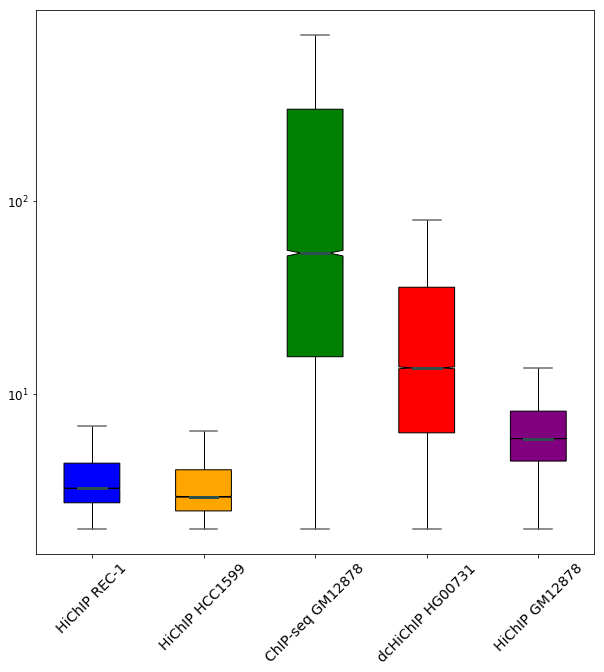

In [24]:
## Distribution of q-value

stat = "-log10(qvalue)"

pvalue_dict = {"dcHiChIP HG00731":hg00731_smc1_peaks[stat] , 
               "HiChIP GM12878":gm12878_smc1_peaks[stat],
               "HiChIP HCC1599":hcc1599_smc1_peaks[stat], 
               "HiChIP REC-1":rec1_smc1_peaks[stat],
               "ChIP-seq GM12878": chip_sa1_peaks[stat]}

data = pvalue_dict.values()
fig, ax = plt.subplots(figsize=(10,10))
bp = ax.boxplot(data, patch_artist = True, notch ='True', sym="")

ax.set_xticklabels(pvalue_dict.keys())
# ax.set_ylabel("log")
ax.set_yscale('log')
for median in bp['medians']:
    median.set(color ='darkslategray',linewidth = 3)
colors = ['blue', 'orange','green', 'red', "purple"]
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
for cap in bp['caps']: 
    cap.set(color ='dimgrey',linewidth = 1.5)

plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,       # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True)  # labels along the bottom edge are off

plt.xticks(rotation=45, fontsize=14)
plt.yticks([10,100],rotation=0, fontsize=12)

#ax.set_yticklabels([])
#ax.set_xticklabels([])

plt.minorticks_off()

#plt.savefig(f"/home/abhishek/Desktop/log10(qvalue).svg",bbox_inches='tight')
#plt.savefig(f"/home/abhishek/Desktop/log10(qvalue).png", dpi=300, bbox_inches='tight')

#plt.savefig(f"/home/abhishek/Desktop/log10(qvalue)_No_L&L.svg",bbox_inches='tight')
#plt.savefig(f"/home/abhishek/Desktop/log10(qvalue)_No_L&L.png", dpi=300, bbox_inches='tight')

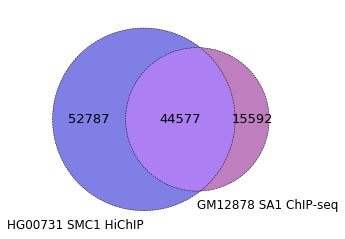

In [29]:
## Common Peaks [HG00731 SMC1 HiChIP vs GM12878 SA1 ChIP-seq]

subs = (52787, 15592, 44577)
labels = ("HG00731 SMC1 HiChIP", "GM12878 SA1 ChIP-seq")
out = venn2(subs, set_labels=labels, set_colors=('mediumblue', 'purple'), alpha=0.50)
venn2_circles(subsets=subs, linewidth=0.5, linestyle="dashed")
for text in out.subset_labels:
    text.set_fontsize(13)
    text.set_color("black")
for idx, subset in enumerate(out.subset_labels):
    out.subset_labels[idx].set_visible(True)
#plt.savefig("/home/abhishek/Desktop/hg00731_smc1_vs_gm12878_chip_sa1_venn_notext_nolables.png", dpi=300, bbox_inches='tight')

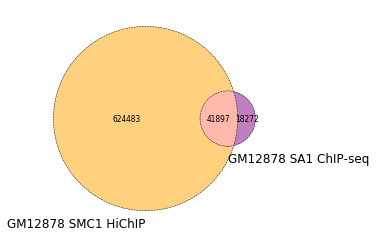

In [30]:
## Common Peaks [HG00731 SMC1 HiChIP vs GM12878 SA1 ChIP-seq]

sub = (624483, 18272, 41897)
labels = ("GM12878 SMC1 HiChIP", "GM12878 SA1 ChIP-seq")
out = venn2(sub, set_labels=labels, set_colors=('orange', 'purple'), alpha=0.5)
venn2_circles(subsets=sub, linewidth=0.5, linestyle="dashed")
for text in out.subset_labels:
    text.set_fontsize(7.5)
for idx, subset in enumerate(out.subset_labels):
    out.subset_labels[idx].set_visible(True)
#plt.savefig("/home/abhishek/Desktop/gm12878_smc1a_vs_gm12878_chip_sa1_venn_notext_nolabels.png", dpi=300, bbox_inches='tight')

In [ ]:
## GM12878 ChIP and no-ChIP comaprison

loops1 = pd.read_csv(mumbach_ctcf_l, sep="\t")
loops2 = pd.read_csv(mumbach_ctcf_chip_l, sep="\t")

#loops_common_0_perc = common_wrapper({"no chip": loops1, "with chip": loops2})
#lop_0_perc = calculate_percentages(loops_common_0_perc)
#np.savetxt("/media/ztojek/DATA/data/cohesin_project/gm12878_ctcf_hichip_with_chip/gm12878_with_and_without_chip_0kb_tolerance_percentage.txt", lop_0_perc)

loops_common_15 = common_wrapper({"no chip": loops1, "with chip": loops2},tolerance=15000)
lop_15_perc = calculate_percentages(loops_common_15)
np.savetxt("/media/ztojek/DATA/data/cohesin_project/gm12878_ctcf_hichip_with_chip/gm12878_with_and_without_chip_15kb_tolerance_percentage.txt", lop_15_perc)


# Plot Heatmaps with Labels
def plot_common_loops_scaled(heatmap, labels, outfile=None, show_numbers=True, scale=False):
    fig, ax = plt.subplots(figsize=(13, 10))
    if scale:
        im = ax.imshow(heatmap, vmin=0, vmax=100)
    else:
        im = ax.imshow(heatmap,vmin=0, vmax=100)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, fontsize=18)
    ax.set_yticklabels(labels, fontsize=18)
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel("[%] common loops", rotation=-90, va="bottom", fontsize=16)
    cbar.ax.tick_params(labelsize=16)
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    if show_numbers:
        for i in range(len(labels)):
            for j in range(len(labels)):
                text = ax.text(j, i, int(heatmap[i, j]),
                               ha="center", va="center", color="black", fontsize=22)
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(heatmap.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(heatmap.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)
    fig.tight_layout()
    if outfile:
        plt.savefig(outfile, dpi=300)
    plt.show()
    
# Plot Heatmaps without Labels 
def plot_common_loops_scaled_nolables(heatmap, labels, outfile=None, show_numbers=True, scale=False):
    fig, ax = plt.subplots(figsize=(13, 10))
    if scale:
        im = ax.imshow(heatmap)
    else:
        im = ax.imshow(heatmap,vmin=0, vmax=100)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels(labels, fontsize=18)
    ax.set_yticklabels(labels, fontsize=18)
    cbar = ax.figure.colorbar(im, ax=ax)
    #cbar.ax.set_ylabel("[%] common loops", rotation=-90, va="bottom", fontsize=16)
    cbar.ax.tick_params(labelsize=18)
    cbar.set_ticklabels([])
    #plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    plt.setp(ax.get_xticklabels(), visible=False) ## Hide tick lables of X-axis
    plt.setp(ax.get_yticklabels(), visible=False) ## Hide tick lables of Y-axis
    if show_numbers:
        for i in range(len(labels)):
            for j in range(len(labels)):
                text = ax.text(j, i, int(heatmap[i, j]),ha="center", va="center", color="w", fontsize=18)
                text.set_visible(False) ##Hide Values within Box
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(heatmap.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(heatmap.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)
    fig.tight_layout()
    if outfile:
        plt.savefig(outfile, dpi=300)
        plt.show()
    

plot_common_loops_scaled(heatmap=lop_15_perc, 
                         labels=["Without ChIP", "With ChIP"],
                         show_numbers=True, 
                         outfile="/home/abhishek/Desktop/gm12878_loops_with_and_without_chip_15kb_tolerance.png")

plot_common_loops_scaled(heatmap=lop_15_perc, 
                         labels=["Without ChIP", "With ChIP"],
                         show_numbers=True, 
                         outfile="/home/abhishek/Desktop/gm12878_loops_with_and_without_chip_15kb_tolerance.svg")
plot_common_loops_scaled_nolables(heatmap=lop_15_perc, labels=["Without ChIP", "With ChIP"],
                         outfile="/home/abhishek/Desktop/gm12878_loops_with_and_without_chip_15kb_tolerance_nol&l.png")

plot_common_loops_scaled_nolables(heatmap=lop_15_perc, labels=["Without ChIP", "With ChIP"],
                         outfile="/home/abhishek/Desktop/gm12878_loops_with_and_without_chip_15kb_tolerance_nol&l.svg")

In [ ]:
## Overlap between loops

# heat_maps = common_wrapper(loops)
# maps_0_perc = calculate_percentages(heat_maps)
# np.savetxt("/home/abhishek/Desktop/maps_interactions_matr_0kb_tolerance.txt", heat_maps)
# np.savetxt("/home/abhishek/Desktop/maps_interactions_matr_0kb_tolerance_percentage.txt", heat_maps)

maps_heat_tolerance_15kb = common_wrapper(loops, tolerance=15000)
maps_15_perc = calculate_percentages(maps_heat_tolerance_15kb)
np.savetxt("/home/abhishek/Desktop/maps_interactions_matr_15kb_tolerance.txt", maps_heat_tolerance_15kb)
np.savetxt("/home/abhishek/Desktop/maps_interactions_matr_15kb_tolerance_percentage.txt", maps_heat_tolerance_15kb)

plot_common_loops(heatmap=maps_15_perc, labels=labelss, outfile="/home/abhishek/Desktop/maps_common_interactions_15kb_tolerance.png")
plot_common_loops(heatmap=maps_15_perc, labels=labelss, outfile="/home/abhishek/Desktop/maps_common_interactions_15kb_tolerance.svg")

plot_common_loops_nolabels(heatmap=maps_15_perc, labels=labelss, outfile="/home/abhishek/Desktop/maps_common_interactions_15kb_tolerance_(nolables_&_nolegends).png")
plot_common_loops_nolabels(heatmap=maps_15_perc, labels=labelss, outfile="/home/abhishek/Desktop/maps_common_interactions_15kb_tolerance_(nolables_&_nolegends).svg")

In [ ]:
## Aggregate peak analysis (APA)

hg_smc1_vc_hic_f = "/home/abhishek/Desktop/Cohesin_kz/cohesin_project_materials_zofia/apa/hg00731_smc1/apa_maps_vc_sqrt/5000/gw/APA.txt"
hg_ctcf_vc_hic_f = "/home/abhishek/Desktop/Cohesin_kz/cohesin_project_materials_zofia/apa/hg00731_ctcf/maps_sqrt//5000/gw/APA.txt"
gm12878_smc1_f = "/home/abhishek/Desktop/Cohesin_kz/cohesin_project_materials_zofia/apa/smc1_mumbach/maps_sqrt//5000/gw/APA.txt"
gm12878_ctcf_f = "/home/abhishek/Desktop/Cohesin_kz/cohesin_project_materials_zofia/apa/ctcf_mumbach/maps_vc_sqrt//5000/gw/APA.txt"
rec1_smc1_f = "/home/abhishek/Desktop/Cohesin_kz/cohesin_project_materials_zofia/apa/rec1/maps_sqrt/5000/gw/APA.txt"
hc_smc1_f = "/home/abhishek/Desktop/Cohesin_kz/cohesin_project_materials_zofia/apa/hcc/maps_sqrt/5000/gw/APA.txt"

values1 = read_apa(hg_smc1_vc_hic_f)    #6.9
values2 = read_apa(gm12878_smc1_f)      #4.1
values3 = read_apa(hc_smc1_f)           #3.2
values4 = read_apa(rec1_smc1_f)         #2.9
values5 = read_apa(hg_ctcf_vc_hic_f)    #7.3
values6 = read_apa(gm12878_ctcf_f)      #4.6

#HG00731_smc1
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(values1, cmap="gist_heat_r", alpha=1)
cbar = ax.figure.colorbar(im, ax=ax,ticks=[20000,60000,100000,140000,180000])
#cbar.ax.set_ylabel("loops", rotation=-90, va="bottom", fontsize=16)
plt.locator_params(axis='both', nbins=3)
ax.set_xticks(ticks=[0, 10, 20], labels=[ ], fontsize=25,)
ax.set_yticks(ticks=[0, 10, 20], labels=[ ], fontsize=25)
plt.title(' ',fontsize = 50)
plt.savefig("/home/abhishek/Desktop/Cohesin_kz/figures/figure_main/figure_2/apa_figure_without_lables/hg00731_smc1.png", dpi=900, bbox_inches='tight')
plt.savefig("/home/abhishek/Desktop/Cohesin_kz/figures/figure_main/figure_2/apa_figure_without_lables/hg00731_smc1.svg",bbox_inches='tight')

#GM12878_smc1
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(values2, cmap="gist_heat_r", alpha=1)
cbar = ax.figure.colorbar(im, ax=ax,ticks=[20000,60000,100000,140000,180000])
#cbar.ax.set_ylabel("loops", rotation=-90, va="bottom", fontsize=16)
plt.locator_params(axis='both', nbins=3)
ax.set_xticks(ticks=[0, 10, 20], labels=[ ], fontsize=25,)
ax.set_yticks(ticks=[0, 10, 20], labels=[ ], fontsize=25)
plt.title(' ',fontsize = 50)
plt.savefig("/home/abhishek/Desktop/Cohesin_kz/figures/figure_main/figure_2/apa_figure_without_lables/gm12878_smc1.png", dpi=900, bbox_inches='tight')
plt.savefig("/home/abhishek/Desktop/Cohesin_kz/figures/figure_main/figure_2/apa_figure_without_lables/gm12878_smc1.svg", bbox_inches='tight')

#hcc1599_smc1
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(values3, cmap="gist_heat_r", alpha=1)
cbar = ax.figure.colorbar(im, ax=ax,ticks=[25000,50000,75000,100000,125000])
#cbar.ax.set_ylabel("loops", rotation=-90, va="bottom", fontsize=16)
plt.locator_params(axis='both', nbins=3)
ax.set_xticks(ticks=[0, 10, 20], labels=[ ], fontsize=25,)
ax.set_yticks(ticks=[0, 10, 20], labels=[ ], fontsize=25)
plt.title(' ',fontsize = 50)
plt.savefig("/home/abhishek/Desktop/Cohesin_kz/figures/figure_main/figure_2/apa_figure_without_lables/hcc1599.png", dpi=900, bbox_inches='tight')
plt.savefig("/home/abhishek/Desktop/Cohesin_kz/figures/figure_main/figure_2/apa_figure_without_lables/hcc1599.svg", bbox_inches='tight')

#rec1_smc1
fig, ax = plt.subplots(figsize=(6, 6))
ig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(values4, cmap="gist_heat_r", alpha=1)
cbar = ax.figure.colorbar(im, ax=ax,ticks=[25000,50000,75000,100000,125000])
#cbar.ax.set_ylabel("loops", rotation=-90, va="bottom", fontsize=16)
plt.locator_params(axis='both', nbins=3)
ax.set_xticks(ticks=[0, 10, 20], labels=[ ], fontsize=25,)
ax.set_yticks(ticks=[0, 10, 20], labels=[ ], fontsize=25)
plt.title(' ',fontsize = 50)
plt.savefig("/home/abhishek/Desktop/Cohesin_kz/figures/figure_main/figure_2/apa_figure_without_lables/rec1_smc1.png", dpi=900, bbox_inches='tight')
plt.savefig("/home/abhishek/Desktop/Cohesin_kz/figures/figure_main/figure_2/apa_figure_without_lables/rec1_smc1.svg", bbox_inches='tight')

#hg00731_ctcf
fig, ax = plt.subplots(figsize=(6, 6))
ig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(values5, cmap="gist_heat_r", alpha=1)
cbar = ax.figure.colorbar(im, ax=ax,ticks=[10000,20000,30000,40000,50000])
#cbar.ax.set_ylabel("loops", rotation=-90, va="bottom", fontsize=16)
plt.locator_params(axis='both', nbins=3)
ax.set_xticks(ticks=[0, 10, 20], labels=[ ], fontsize=25,)
ax.set_yticks(ticks=[0, 10, 20], labels=[ ], fontsize=25)
plt.title(' ',fontsize = 50)
plt.savefig("/home/abhishek/Desktop/Cohesin_kz/figures/figure_main/figure_2/apa_figure_without_lables/hg00731_ctcf.png", dpi=900, bbox_inches='tight')
plt.savefig("/home/abhishek/Desktop/Cohesin_kz/figures/figure_main/figure_2/apa_figure_without_lables/hg00731_ctcf.svg",bbox_inches='tight')

#gm12878_ctcf
fig, ax = plt.subplots(figsize=(6, 6))
ig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(values6, cmap="gist_heat_r", alpha=1)
cbar = ax.figure.colorbar(im, ax=ax,ticks=[150000,300000,450000,600000,750000])
#cbar.ax.set_ylabel("loops", rotation=-90, va="bottom", fontsize=16)
plt.locator_params(axis='both', nbins=3)
ax.set_xticks(ticks=[0, 10, 20], labels=[ ], fontsize=25,)
ax.set_yticks(ticks=[0, 10, 20], labels=[ ], fontsize=25)
plt.title(' ',fontsize = 50)
plt.savefig("/home/abhishek/Desktop/Cohesin_kz/figures/figure_main/figure_2/apa_figure_without_lables/gm12878_ctcf.png", dpi=900, bbox_inches='tight')
plt.savefig("/home/abhishek/Desktop/Cohesin_kz/figures/figure_main/figure_2/apa_figure_without_lables/gm12878_ctcf.svg", bbox_inches='tight')

502640
[0.00000000e+00 1.98949546e-06 3.97899093e-06 ... 9.99994032e-01
 9.99996021e-01 9.99998011e-01]


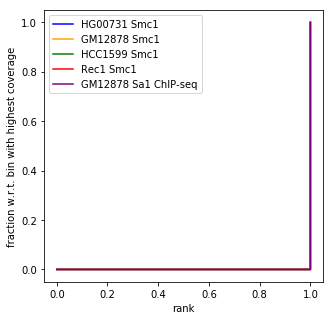

In [58]:
## Fingerprint Analysis

infile = "/home/abhishek/Desktop/Cohesin_kz/fingerprints_cohesin_only_raw_counts"
raw_counts = pd.read_csv(infile, sep="\t", skiprows=[0])
#raw_counts

hg = np.sort(raw_counts["HG00731 Smc1"].to_numpy())
hg=hg/hg[-1]
gm_smc1 = np.sort(raw_counts["GM12878 Smc1"].to_numpy())

total = len(gm_smc1)
gm_smc1 = np.arange(total).astype('float') / total 
gm_smc1 = gm_smc1/gm_smc1[-1]
count = np.cumsum(np.sort(gm_smc1))
count = count / count[-1]

hcc = np.sort(raw_counts["HCC1599 Smc1"].to_numpy())
hcc = hcc/hcc[-1]
rec1 = np.sort(raw_counts["Rec1 Smc1"].to_numpy())
rec1 = rec1/rec1[-1]
chip = np.sort(raw_counts["GM12878 Sa1 ChIP-seq"].to_numpy())
chip = chip/chip[-1]

num_reads_per_bin = raw_counts.to_numpy()
total = len(num_reads_per_bin[:,0])
print(total)
x = np.arange(total).astype('float') / total 
print(x)
labels = raw_counts.columns
pyplot_line_styles = sum([7 * ["-"], 7 * ["--"], 7 * ["-."], 7 * [":"]], [])
colors = ['blue', 'orange','green', 'red', "purple"]

fig, ax = plt.subplots(figsize=(5,5))
for i, reads in enumerate(num_reads_per_bin.T):
        count = np.cumsum(np.sort(reads))
        count = count / count[-1]
        j = i % len(pyplot_line_styles)
        plt.plot(x, count, label=labels[i], linestyle=pyplot_line_styles[j], color=colors[i])
        plt.xlabel('rank')
        plt.ylabel('fraction w.r.t. bin with highest coverage')
        plt.legend(loc='upper left')
#plt.savefig("/home/abhishek/Desktop/image.svg", dpi=100, bbox_inches=0)

In [ ]:
## 3d and non-3d Peaks

hg00731_smc1_3d_peaks = pd.DataFrame(filter_peaks(hg00731_smc1_peaks, hg00731_smc1_loops), columns=smc1_peaks.columns)
hg00731_ctcf_3d_peaks = pd.DataFrame(filter_peaks(hg00731_ctcf_peaks, hg00731_ctcf_loops), columns=smc1_peaks.columns)
gm12878_smc1_3d_peaks = pd.DataFrame(filter_peaks(gm12878_smc1_peaks, gm12878_smc1_loops), columns=smc1_peaks.columns)
gm12878_ctcf_3d_peaks = pd.DataFrame(filter_peaks(gm12878_ctcf_peaks, gm12878_ctcf_loopss), columns=smc1_peaks.columns)
rec1_smc1_3d_peaks    = pd.DataFrame(filter_peaks(rec1_smc1_peaks, rec1_smc1_loops), columns=smc1_peaks.columns)
hcc1599_smc1_3d_peaks = pd.DataFrame(filter_peaks(hcc1599_smc1_peaks, hcc1599_smc1_loops), columns=smc1_peaks.columns)


hg00731_smc1_3d_peaks.to_csv("/home/abhishek/Desktop/Cohesin_kz/peaks/qval_001/hg00731_smc1_qval001_3dpeaks.bed", sep="\t", header=False, index=False)
hg00731_ctcf_3d_peaks.to_csv("/home/abhishek/Desktop/Cohesin_kz/peaks/qval_001/hg00731_ctcf_qval001_3dpeaks.bed", sep="\t", header=False, index=False)
gm12878_smc1_3d_peaks.to_csv("/home/abhishek/Desktop/Cohesin_kz/peaks/qval_001/mumbach_smc1_qval001_3dpeaks.bed", sep="\t", header=False, index=False)
gm12878_ctcf_3d_peaks.to_csv("/home/abhishek/Desktop/Cohesin_kz/peaks/qval_001/mumbach_ctcf_qval001_3dpeaks.bed", sep="\t", header=False, index=False)
rec1_smc1_3d_peaks.to_csv("/home/abhishek/Desktop/Cohesin_kz/peaks/qval_001/rec1_qval001_3dpeaks.bed", sep="\t", header=False, index=False)
hcc1599_smc1_3d_peaks.to_csv("/home/abhishek/Desktop/Cohesin_kz/peaks/qval_001/hcc_qval001_3dpeaks.bed", sep="\t", header=False, index=False)


hg00731smc1_no_loops = pd.merge(hg00731_smc1_peaks, hg00731_smc1_3d_peaks, indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=1)
hg00731ctcf_no_loops = pd.merge(hg00731_ctcf_peaks, hg00731_ctcf_3d_peaks, indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=1)
gm12878smc1_no_loops = pd.merge(gm12878_smc1_peaks,gm12878_smc1_3d_peaks, indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=1)
gm12878ctcf_no_loops = pd.merge(gm12878_ctcf_peaks,gm12878_ctcf_3d_peaks, indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=1)
rec1_no_loops = pd.merge(rec1_smc1_peaks,rec1_smc1_3d_peaks, indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=1)
hcc1599_no_loops = pd.merge(hcc1599_smc1_peaks,hcc1599_smc1_3d_peaks, indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=1)

hg00731smc1_no_loops.to_csv("/home/abhishek/Desktop/Cohesin_kz/peaks/qval_001/hg00731_smc1_qval001_no3dpeaks.bed", sep="\t", header=False, index=False)
hg00731ctcf_no_loops.to_csv("/home/abhishek/Desktop/Cohesin_kz/peaks/qval_001/hg00731_ctcf_qval001_no3dpeaks.bed", sep="\t", header=False, index=False)
gm12878smc1_no_loops.to_csv("/home/abhishek/Desktop/Cohesin_kz/peaks/qval_001/mumbach_smc1_qval001_no3dpeaks.bed", sep="\t", header=False, index=False)
gm12878ctcf_no_loops.to_csv("/home/abhishek/Desktop/Cohesin_kz/peaks/qval_001/mumbach_ctcf_qval001_no3dpeaks.bed", sep="\t", header=False, index=False)
rec1_no_loops.to_csv("/home/abhishek/Desktop/Cohesin_kz/peaks/qval_001/rec1_qval001_no3dpeaks.bed", sep="\t", header=False, index=False)
hcc1599_no_loops.to_csv("/home/abhishek/Desktop/Cohesin_kz/peaks/qval_001/hcc_qval001_no3dpeaks.bed", sep="\t", header=False, index=False)